# HW2 by Zijie Chen

# Practical 7 Part 2B
The goal of this part of the practical is to take a real image containing
a planar black square and figure out the transformation between the square
and the camera.  We will then draw a wire-frame cube with it's base
corners at the corner of the square.  You should use this
template for your code and fill in the missing sections marked "TO DO"

We built the components we need in part 2A, so half the battle is complete! And you can copy those functions over. Now we'd like to make something cool. We have an image with a plane in world space. We're given the location of some points that lie on the plane and their corresponding image space points. We can use these to estimate a transformation matrix `TEst`. 

We can then use this transformation matrix and the camera instrinsics to project a 3D cube into image space! First step on the ladder to AR.

## Import libraries 

In [2]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Load and display the image

The red points mark the coordinates of the corners of the points on the plane (corners of the square) in image space. 

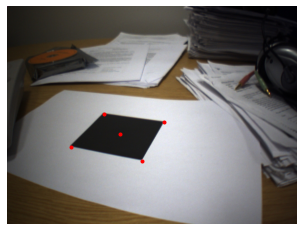

In [3]:
# Load image:
im = plt.imread('test104.jpg')

# Define points on image
XImCart = np.array([[140.3464,  212.1129,  346.3065,  298.1344,   247.9962],
             [308.9825,  236.7646,  255.4416,  340.7335,   281.5895]])

# Define 3D points of plane
XCart = np.array([[-50, -50,  50,  50, 0],
          [50, -50, -50,  50, 0],
          [0,   0,   0,   0, 0]])

# We assume that the intrinsic camera matrix K is known and has values:
K = np.array([[640,  0,  320],
             [0, 640, 240],
             [0,  0,  1]])

# Draw image and 2d points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.axis('off')
plt.show()

### You've already implemented all of these functions in previous sections, so just copy them over to here. 

In [4]:
# This function is already defined in Practical 2A

def projectiveCamera(K,T,XCart):
    ##TODO
    # The goal of this function is to project points in XCart through projective camera
    # defined by intrinsic matrix K and extrinsic matrix T. In essence, this function takes a set of points 
    # in 3D world space, XCart, and projects them into camera image space by applying the extrinsic matrix T 
    # and then applying the intrinsic matrix K.
    # 
    # There are three steps.
    # 1) Move from world space to camera space. 
    #            camera space points = extrinsics T * world space points 
    #
    # 2) Applying the intrinsics matrix to the camera space points after normalizing
    #           homogeneous image space points = K * normalized camera space points
    # 
    # 3) Move to image space cartesian points from image space homogeneous points, involves a 
    # normalization using the third row.
    
    
    # TO DO: Replace this
    # XImCart = []

    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    XHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)
    
    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    Camera = T @ XHom
    
    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    xCamHom = np.delete(Camera, 3, 0)
    
    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    img = K @ xCamHom
    
    # TO DO: Convert points back to Cartesian coordinates xImCart
    XImCart = img[0:2,:] / np.tile([img[2,:]],(2,1))
    
    return XImCart



In [5]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 

    U,L,V_T = np.linalg.svd(A)
    h = V_T.T[:,-1]
  
    return h

In [6]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    H = np.identity(3)

    # H = np.array([[0.6, 0.7, -100.],
    #           [1.0, 0.6, 50.],
    #           [0.001, 0.002, 1.0]])

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = np.zeros((n_points * 2, 9))
    for i in range(4):
        A[2*i,3] = -pts1Hom[0,i]
        A[2*i,4] = -pts1Hom[1,i]
        A[2*i,5] = -1
        A[2*i,6] = pts2Hom[1,i] * pts1Hom[0,i]
        A[2*i,7] = pts2Hom[1,i] * pts1Hom[1,i]
        A[2*i,8] = pts2Hom[1,i]
        A[2*i+1,0] = pts1Hom[0,i]
        A[2*i+1,1] = pts1Hom[1,i]
        A[2*i+1,2] = 1
        A[2*i+1,6] = -pts2Hom[0,i]*pts1Hom[0,i]
        A[2*i+1,7] = -pts2Hom[0,i]*pts1Hom[1,i]
        A[2*i+1,8] = -pts2Hom[0,i]

    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    

    # Reshape h into the matrix H, values of h go first into rows of H
    H[0,:] = h[0:3]
    H[1,:] = h[3:6]
    H[2,:] = h[6:9]
    
    return H

In [7]:
def estimatePlanePose(XImCart,XCart,K):
    # The goal of this function is to estimate the pose of a plane relative to camera (extrinsic matrix)
    # given points in image space xImCart, points in 3D world space XCart, and an intrinsics matrix K.
    
    # TO DO: replace this
    T = np.zeros((4,4))
    T[-1,-1] = 1

    # TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
    
    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    XCamCart = XCamHom[0:2,:] / np.tile([XCamHom[2,:]],(2,1))
    H = calcBestHomography(XCart, XCamCart)
          
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    U, L, V_T = np.linalg.svd(H[:,0:2])
    R_12 = U @ np.array([[1,0],[0,1],[0,0]]) @ V_T
    R_12 = R_12.reshape(3,2)

    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R_3 = np.cross(R_12[:,0], R_12[:,1])
    R_3 = R_3.reshape(3,1)
        
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    rotation = np.hstack((R_12,R_3))
    if np.linalg.det(rotation) < 0:
        rotation[:,-1] = -rotation[:,-1]
    
    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    temp = 0
    for i in range(3):
        for j in range(2):
            temp += H[i,j]/rotation[i,j]
    lambda_p = temp/6

    tau = H[:,2]/lambda_p
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if tau[-1] < 0:
        tau = -tau
        R_12 = -R_12

    T[0:3,0:3] = rotation
    T[0:3,-1] = tau
            
    # TO DO: Assemble transformation into matrix form

    
    return T 

## Final coding bit

We can estimate `TEst` using `XImCart` and `XCart` with the method `estimatePlanePose`. We can then use this estimated extrinsics transformation and the camera instrinsics to project 3D cube points into 2D camera image space.

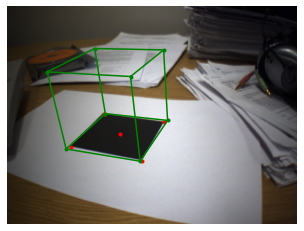

In [38]:
# TO DO: Use your routine to calculate TEst, the extrinsic matrix relating the
# plane position to the camera position. You'll need to use estimatePlanePose.

# TEst = []
TEst = np.eye(4)
TEst = estimatePlanePose(XImCart, XCart, K)

# Define 3D points of plane
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
                              [50, -50, -50,  50,  50, -50, -50,  50],
                              [0,   0,   0,   0, -100, -100, -100, -100]]);


# TO DO: Draw a wire frame cube, by projecting the vertices of a 3D cube through
# the projective camera and drawing lines betweeen the resulting 2d image points.
# You'll need to use projectiveCamera.
XWireFrameCartProjected = np.array([[0], [0]])
XWireFrameCartProjected = projectiveCamera(K, TEst, XWireFrameCart)

# Draw image, 2d points and projected 3D cube points
plt.imshow(im)
plt.plot(XImCart[0,],XImCart[1,],'r.')
plt.plot(XWireFrameCartProjected[0,],XWireFrameCartProjected[1,],'g.')

plt.plot([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,1]], [XWireFrameCartProjected[1,0],XWireFrameCartProjected[1,1]], 'g-')
plt.plot([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,3]], [XWireFrameCartProjected[1,0],XWireFrameCartProjected[1,3]], 'g-')
plt.plot([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,4]], [XWireFrameCartProjected[1,0],XWireFrameCartProjected[1,4]], 'g-')
plt.plot([XWireFrameCartProjected[0,6], XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,6],XWireFrameCartProjected[1,7]], 'g-')
plt.plot([XWireFrameCartProjected[0,6], XWireFrameCartProjected[0,5]], [XWireFrameCartProjected[1,6],XWireFrameCartProjected[1,5]], 'g-')
plt.plot([XWireFrameCartProjected[0,6], XWireFrameCartProjected[0,2]], [XWireFrameCartProjected[1,6],XWireFrameCartProjected[1,2]], 'g-')
plt.plot([XWireFrameCartProjected[0,5], XWireFrameCartProjected[0,1]], [XWireFrameCartProjected[1,5],XWireFrameCartProjected[1,1]], 'g-')
plt.plot([XWireFrameCartProjected[0,5], XWireFrameCartProjected[0,4]], [XWireFrameCartProjected[1,5],XWireFrameCartProjected[1,4]], 'g-')
plt.plot([XWireFrameCartProjected[0,3], XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,3],XWireFrameCartProjected[1,7]], 'g-')
plt.plot([XWireFrameCartProjected[0,3], XWireFrameCartProjected[0,2]], [XWireFrameCartProjected[1,3],XWireFrameCartProjected[1,2]], 'g-')
plt.plot([XWireFrameCartProjected[0,4], XWireFrameCartProjected[0,7]], [XWireFrameCartProjected[1,4],XWireFrameCartProjected[1,7]], 'g-')
plt.plot([XWireFrameCartProjected[0,1], XWireFrameCartProjected[0,2]], [XWireFrameCartProjected[1,1],XWireFrameCartProjected[1,2]], 'g-')

plt.axis('off')
plt.show()

Comment:

The red dots in the image represent the centrol point and four conners of the black area. The four nodes of the base of the cube are very closed
to the conners of the black square area. The result is reasonable and acceptable.

### QUESTIONS TO THINK ABOUT...

Do the results look realistic?
If not, then what factors do you think might be causing this?